# Lab | Customer Analysis Round 7

Remember the previous rounds. Follow the steps as shown in previous lectures and try to improve the accuracy of the model. Include both categorical columns in the exercise. Some approaches you can try in this exercise:

  1. use the concept of multicollinearity and remove insignificant variables
  2. use a different method of scaling the numerical variables
  3. use a different ratio of train test split
  4. use the transformation on numerical columns which align it more towards a normal distribution



In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("marketing_customer_analysis.csv")
data.head(3) #importing and checking our data

,Customer,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Total Claim Amount,Vehicle Class,Vehicle Size
0,BU79786,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,384.811147,Two-Door Car,Medsize
1,QZ44356,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,1131.464935,Four-Door Car,Medsize
2,AI49188,Nevada,12887.431650,No,Premium,Bachelor,2/19/11,Employed,F,48767,...,38,0,2,Personal Auto,Personal L3,Offer1,Agent,566.472247,Two-Door Car,Medsize


In [3]:
data = data[['Customer', 'State', 'Customer Lifetime Value', 'Response', 'Coverage',
       'Education', 'Effective To Date', 'EmploymentStatus', 'Gender',
       'Income', 'Location Code', 'Marital Status', 'Monthly Premium Auto',
       'Months Since Last Claim', 'Months Since Policy Inception',
       'Number of Open Complaints', 'Number of Policies', 'Policy Type',
       'Policy', 'Renew Offer Type', 'Sales Channel',
       'Vehicle Class', 'Vehicle Size', 'Total Claim Amount']] #just putting the target variable to the end of this list cause I like it more. 

In [5]:
numerical = data.select_dtypes(np.number)
numerical.head(3) #selecting the numerical data

,Customer Lifetime Value,Income,Monthly Premium Auto,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Total Claim Amount
0,2763.519279,56274,69,32,5,0,1,384.811147
1,6979.535903,0,94,13,42,0,8,1131.464935
2,12887.431650,48767,108,18,38,0,2,566.472247


In [10]:
categorical = data.select_dtypes(np.object)
categorical.head(3) #selecting the categorical data

C:\Users\lazar\AppData\Local\Temp\ipykernel_5432\2666177852.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical = data.select_dtypes(np.object)


,State,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Location Code,Marital Status,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size
0,Washington,No,Basic,Bachelor,2/24/11,Employed,F,Suburban,Married,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize
1,Arizona,No,Extended,Bachelor,1/31/11,Unemployed,F,Suburban,Single,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize
2,Nevada,No,Premium,Bachelor,2/19/11,Employed,F,Suburban,Married,Personal Auto,Personal L3,Offer1,Agent,Two-Door Car,Medsize


Just looking at our categorical columns we can imagine that the customer feature can be removed as (in my opinion) it doesn't contribute in any way to our regression model. We'll do that later and also perform a train split test to separate explanatory and target variables. But first let's have a look at multicollinearity.

In [7]:
data = data.drop(['Customer'],axis=1)

In [8]:
data.head(2)

,State,Customer Lifetime Value,Response,Coverage,Education,Effective To Date,EmploymentStatus,Gender,Income,Location Code,...,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Policy Type,Policy,Renew Offer Type,Sales Channel,Vehicle Class,Vehicle Size,Total Claim Amount
0,Washington,2763.519279,No,Basic,Bachelor,2/24/11,Employed,F,56274,Suburban,...,5,0,1,Corporate Auto,Corporate L3,Offer1,Agent,Two-Door Car,Medsize,384.811147
1,Arizona,6979.535903,No,Extended,Bachelor,1/31/11,Unemployed,F,0,Suburban,...,42,0,8,Personal Auto,Personal L3,Offer3,Agent,Four-Door Car,Medsize,1131.464935


## Checking Multicollinearity 

We've briefly checked before on multicollinearity in previous labs but it's time to dive in further now. I'll start with the numerical variables. 

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor 
#I could use a bivariate analysis but I think that may not show any more potentially complex issues of multicollinearity thus I'll use VIFs.

In [12]:
num = numerical.iloc[:,:-1] #since total amount claim is our later target variable.

In [13]:
def calc_vif(num):

    # Calculating VIF just for the numerical features for starters
    vif = pd.DataFrame()
    vif["variables"] = num.columns
    vif["VIF"] = [variance_inflation_factor(num.values, i) for i in range(num.shape[1])]

    return(vif)

In [14]:
calc_vif(num)

,variables,VIF
0,Customer Lifetime Value,2.805772
1,Income,2.278732
2,Monthly Premium Auto,6.363674
3,Months Since Last Claim,2.782622
4,Months Since Policy Inception,3.265764
5,Number of Open Complaints,1.166609
6,Number of Policies,2.297052


A high VIF score (VIF > 5 or 10) often suggests high multicollinearity between this independent variable and the others. We see here that the feature Monthly Premium Auto indeed is presenting a VIFscore great than 5. In order to reduce multicollinearity in this case we'll try dropping this feature.

In [15]:
num = num.drop(['Monthly Premium Auto'],axis=1)
calc_vif(num)

,variables,VIF
0,Customer Lifetime Value,2.110714
1,Income,2.172452
2,Months Since Last Claim,2.517459
3,Months Since Policy Inception,2.812209
4,Number of Open Complaints,1.158769
5,Number of Policies,2.189924


In [16]:
#dropping Monthly Premium Auto from our data
data = data.drop(['Monthly Premium Auto'],axis=1)

Our explanatory numerical variables look good for now. Before we use VIF on any categorical explanatory variables we need to encode them.

In [39]:
new_data = data.drop(['State', 'Effective To Date'],axis=1) 
#I've made here the executive decision to drop features state and effective to date cause I was getting too many rows.
#My idea is that they may end up creating noise but I'm not sure if my approach is correct.

## Dummifying

In [40]:
X = new_data.iloc[:, :-1] #X y split on the entire data
y = new_data.iloc[:, -1]

In [41]:
y #sanity check

0        384.811147
1       1131.464935
2        566.472247
3        529.881344
4        138.130879
           ...     
9129     198.234764
9130     379.200000
9131     790.784983
9132     691.200000
9133     369.600000
Name: Total Claim Amount, Length: 9134, dtype: float64

In [46]:
X = pd.get_dummies(X, drop_first=True) #encoding the categorical variables
X.head(3)

,Customer Lifetime Value,Income,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Response_Yes,Coverage_Extended,Coverage_Premium,Education_College,...,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_Luxury Car,Vehicle Class_Luxury SUV,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Medsize,Vehicle Size_Small
0,2763.519279,56274,32,5,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,6979.535903,0,13,42,0,8,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
2,12887.431650,48767,18,38,0,2,0,0,1,0,...,0,0,0,0,0,0,0,1,1,0


In [47]:
calc_vif(X)

C:\Users\lazar\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,Customer Lifetime Value,2.790102
1,Income,7.840546
2,Months Since Last Claim,3.183521
3,Months Since Policy Inception,3.856353
4,Number of Open Complaints,1.187794
5,Number of Policies,2.545410
6,Response_Yes,1.415287
7,Coverage_Extended,1.516350
8,Coverage_Premium,1.191914
9,Education_College,1.961974


We can see that there are still some variables that are presenting multicollinearity. I'll use the somewhat consevative threshold of VIF > 5 to remove such variables. In this case these are Income, EmploymentStatus_Employed and Vehicle Size_Medsize. I also noticed that I'm getting inf values but I really don't know how to deal with that so for now I'll just leave it as it is.

In [50]:
X = X.drop(['Income', 'EmploymentStatus_Employed', 'Vehicle Size_Medsize'],axis=1)

KeyError: "['Income', 'EmploymentStatus_Employed', 'Vehicle Size_Medsize'] not found in axis"

In [51]:
X.head(3)

,Customer Lifetime Value,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Response_Yes,Coverage_Extended,Coverage_Premium,Education_College,Education_Doctor,...,Renew Offer Type_Offer4,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_Luxury Car,Vehicle Class_Luxury SUV,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Small
0,2763.519279,32,5,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,6979.535903,13,42,0,8,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,12887.431650,18,38,0,2,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [52]:
#running a VIF check just one last time
calc_vif(X)

C:\Users\lazar\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,variables,VIF
0,Customer Lifetime Value,2.751403
1,Months Since Last Claim,3.128487
2,Months Since Policy Inception,3.711358
3,Number of Open Complaints,1.181750
4,Number of Policies,2.505886
5,Response_Yes,1.410106
6,Coverage_Extended,1.509004
7,Coverage_Premium,1.189176
8,Education_College,1.941441
9,Education_Doctor,1.133894


## Train test Split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.25, random_state=0)

This time I'm taking a larger test size than the first time (original test_size = 0.2) hoping for a clearer understanding. However the risk I'm taking now is that with less training data, the model may show high variance in training (to the best of my understanding). Let's see! 

In [54]:
X_train.head(3) #my typical sanity checks

,Customer Lifetime Value,Months Since Last Claim,Months Since Policy Inception,Number of Open Complaints,Number of Policies,Response_Yes,Coverage_Extended,Coverage_Premium,Education_College,Education_Doctor,...,Renew Offer Type_Offer4,Sales Channel_Branch,Sales Channel_Call Center,Sales Channel_Web,Vehicle Class_Luxury Car,Vehicle Class_Luxury SUV,Vehicle Class_SUV,Vehicle Class_Sports Car,Vehicle Class_Two-Door Car,Vehicle Size_Small
5190,3585.942995,9,23,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1120,32227.083890,0,8,0,2,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7334,4515.445404,14,44,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
y_train.head(3)

5190    117.871165
1120    572.635987
7334     39.292196
Name: Total Claim Amount, dtype: float64

## Finishing up with Preprocessing / Transforming the data

A rule of thumb that I read about suggested that I should use StandardScaler for normally distributed data, otherwise use MinMaxScaler. We've tried the StandardScaler before, let's try the MinMaxScaler now for our numerical data since we've since from previous labs that it's not normally distributed.

In [57]:
from sklearn.preprocessing import MinMaxScaler

In [58]:
sc_X = MinMaxScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [59]:
X_train #sanity check

array([[0.02072934, 0.25714286, 0.23232323, ..., 0.        , 0.        ,
        0.        ],
       [0.37246782, 0.        , 0.08080808, ..., 0.        , 0.        ,
        0.        ],
       [0.03214444, 0.4       , 0.44444444, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.0763429 , 0.62857143, 0.36363636, ..., 0.        , 0.        ,
        0.        ],
       [0.13517488, 0.85714286, 0.14141414, ..., 0.        , 0.        ,
        0.        ],
       [0.07081417, 0.2       , 0.44444444, ..., 0.        , 0.        ,
        0.        ]])

## Applying the new model

In [61]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [66]:
y_pred_train = regressor.predict(X_train)
y_pred_train

array([ 69.72345755, 581.43475965, 233.74117549, ..., 382.55072848,
       612.78446963, 677.40880013])

In [67]:
y_pred_test = regressor.predict(X_test)
y_pred_test

array([366.0631518 , 493.26753205, 609.61031542, ..., 731.71821732,
       184.50180977, 341.32312611])

## Visualization of predictions

In [69]:
x = y_pred_train
y = y_train
t = np.arange(0, x.size)

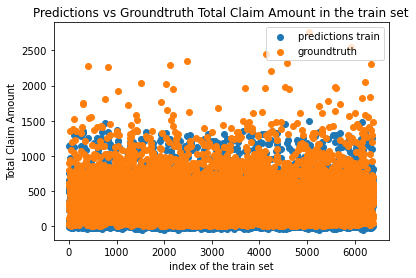

In [70]:
import matplotlib.pyplot as plt # Impot the relevant module

# Create the figure and axes object
fig, ax = plt.subplots()

plt.scatter(t,x) 
plt.scatter(t,y)

# Add Title
plt.title("Predictions vs Groundtruth Total Claim Amount in the train set") 

# Add Axes Labels
plt.xlabel("index of the train set") 
plt.ylabel("Total Claim Amount") 


# Function add a legend  
plt.legend(["predictions train", "groundtruth"], loc ="upper right")
# Display

plt.show()

In [ ]:
#this looks better than my previous lab however, I'm still very unsatisfied with this plot.

## Evaluating the model

In [71]:
print("--- Performances of the model ---")
print("the r2 score on train  :", regressor.score(X_train, y_train))
print("the r2 score on test  :", regressor.score(X_test, y_test))

--- Performances of the model ---
the r2 score on train  : 0.7623696631343865
the r2 score on test  : 0.7454828994545137


Since $R^2_{train}$ > $R^2_{test}$ but only but a little, we can say that our model is slightly overfitting. Additionally, an r2 score of approximately .75 means that the predictors explain about 75% of the variation in our Total Claim Amount variable. Although there is room for improvement, this is a good start.

## Feature importance

In [ ]:
#I had troubles with that part.

In [73]:
regressor.coef_

array([ 3.28804838e+01,  1.15331580e+01,  4.04999704e-01, -7.62065250e+00,
        7.80724499e+00, -2.69130550e+01,  8.62118397e+01,  2.41221258e+02,
       -4.48160756e+00, -1.12072731e+01,  1.60285151e+01, -4.61992125e+00,
        2.02070920e+01,  1.37560736e+01,  8.59947867e+01,  1.33429969e+01,
        3.79373703e+02,  2.18556947e+02, -1.08402062e+01,  5.44469343e+01,
       -6.65530741e+14, -9.15546569e+13, -1.55215335e+01, -8.90191722e+00,
        6.65530741e+14,  6.65530741e+14,  6.65530741e+14,  9.15546569e+13,
        9.15546569e+13,  9.15546569e+13,  1.33307122e+01,  6.28717673e+00,
        4.85083470e+00, -1.00063794e+00, -4.47318882e+00,  7.60266737e-01,
        7.05640645e+02,  6.74408352e+02,  2.06319578e+02,  1.96683748e+02,
        3.66505435e-01,  5.95148373e+00])

In [ ]:
# This is where I got a bit lost and I'd love some feedback on that. 
# I was trying to use something like the code below to show each feature's coefficients:

feature_importance = pd.DataFrame({
    "feature_names": "I think the normalized original data goes here?"
    "coefficients":regressor.coef_
})

feature_importance

In [88]:
intercept = regressor.intercept_ #defining the intercept
intercept

-10.715530365086806

In [ ]:
#I would define feature importance based on coefficients and I'd set coefficients to absolute values so I can rank my features

feature_importance["coefficients_abs"] = feature_importance["coefficients"].abs()

In [ ]:
#and then I would vizualize this with a barplot
sns.catplot(x= "feature_names",y= "coefficients_abs", 
            data= feature_importance.sort_values(by = "coefficients_abs", ascending=False), 
            kind="bar", aspect= 16/9)

### Conclusion

Here I was planning to write a conclusion based on the graphs pointing out which of the features actual hold a strong effect on the Total Amount Claim variable. This would allow the commpany to focus its effort on collecting more data about the high ranking features, or target specific demographics that our model indicates that could result into increased Total Amount Claim.

## Final Ideas for future improvement

Other potential things that I could try: 
 1. Use multicollinearity to also remove insignificant variables. That may reduce the noise and increase my r2 scores.
 2. Use yet another ratio of the train set split.
 3. Try to transform numerical columns in a way that would lead towards normal distribution.

Unfortunately I ran out of time to try out more ideas but this lab was a wild ride (in a good way :D). I'm very happy with playing around and learning more on this topic. I feel I need to practice more but the lab definitely helped. If possible I would realy really appreciate feedback on this lab cause I want to be sure of what I'm doing before I complete the final round lab.